In [1]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import eli5
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import StratifiedKFold
#from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMRegressor
from sklearn.cluster import KMeans
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import KNeighborsRegressor

In [2]:
pd.set_option("max_colwidth", None)
pd.set_option("max_columns", 700)
pd.set_option("max_rows", 700)
na=-999
na2=0
seed=1234
cluster=KMeans(n_clusters=5)
le=LabelEncoder()

In [3]:
# Load files
#path='/kaggle/input/ecde-zindi/'
#train = pd.read_csv(path+'Train.csv')
#test = pd.read_csv(path+'Test.csv')
#ss = pd.read_csv(path+'SampleSubmission.csv')

In [98]:
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')
ss = pd.read_csv('SampleSubmission.csv')
train['train']=1
test['train']=0
df=pd.concat([train, test])

In [99]:
date_cols=[feat for feat in df.columns if 'date' in feat.split('_')] +['child_dob']
for col in date_cols:
    df['year_'+col]=(df[col].str.split('-', expand=True)[0]).astype(float)
    df['month_'+col]=(df[col].str.split('-', expand=True)[1]).astype(float)
    df['yearmonth_'+col]=(df[col].str.split('-', expand=True)[0]+df[col].str.split('-', expand=True)[1]).astype(float)
    df['yearmonthday_'+col]=(df[col].str.split('-', expand=True)[0]+df[col].str.split('-', expand=True)[1] + df[col].str.split('-', expand=True)[2]).astype(float)
    df.drop(col, axis=1, inplace=True)

from sklearn.preprocessing import OrdinalEncoder
cat_cols=df.select_dtypes('O')
le=OrdinalEncoder()
for i in cat_cols:
    if  i != 'child_id':
        df[i]=df[i].fillna(df[i].mode())
        df[i]=df[i].fillna('no')
        df[i]=le.fit_transform(np.array(df[i].astype(str)).reshape(-1, 1))
num_cols=df.select_dtypes('number')
for i in num_cols:
    df[i]=df[i].fillna(df[i].median())



In [100]:
def X_y(df):
    train=df[df['train']==1].drop('train', axis=1)
    test=df[df['train']==0].drop(['target', 'train'], axis=1)
    y = train.target
    num_cols = list(set(test.select_dtypes('number')).intersection(train.select_dtypes('number')))
    X=train[num_cols]
    return X, y

In [101]:
from sklearn.ensemble import RandomForestRegressor
X, y=X_y(df)
rf=RandomForestRegressor(n_estimators=40, criterion='mse')
rf.fit(X, y)

RandomForestRegressor(n_estimators=40)

In [102]:
cols=pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)>0.001
df=df[cols[cols].index.to_list()+['child_id', 'train', 'target']]
df.head()

,child_age,child_observe_total,teacher_emotional_total,child_height,child_zha,id_enumerator,id_facility,yearmonthday_child_date,pri_fees_amount_pv,yearmonthday_child_dob,id_ward,child_observe_diligent,latitude,teacher_social_total,child_observe_attentive,pri_fees_amount,id_facility_n,longitude,month_child_dob,ses_proxy,ward_best,id_ward_n,child_observe_concentrated,quintile,teacher_duration,id_dc_best,gps,prov_best,id_mn_n,child_observe_interested,id_team,id_mn_best,dc_best,language_assessment,id_dc_n,language_child,child_gender,child_years_in_programme,id_prov,mn_best,count_register_all,count_toilets_children,child_grant,yearmonth_child_dob,id_prov_n,teacher_emotional_selfstarter,pri_year,pri_capacity,month_child_date,obs_materials,teacher_emotional_met,obs_area,count_children_present,ses_cat,teacher_social_assistance,teacher_emotional_independent,count_register_year_2019,count_register_year_2016,teacher_social_cooperate,teacher_social_ideas,teacher_emotional_understand,count_children_precovid,pri_language,teacher_social_initiative,yearmonthday_child_enrolment_date,teacher_social_nonaggressive,count_children_attendance,teacher_social_peers,count_register_year_2018,count_register_race_african,count_register_year_2017,facility_type,pra_groupings,child_stunted,child_languages,count_register_year_2020,count_register_year_grader,teacher_emotional_confidence,obs_handwashing,child_attendance,pri_facilities,obs_equipment,count_register_race_coloured,pri_calc_time_close,count_register_gender_female,count_register_gender_male,pri_land,pri_meal,teacher_selfcare_total,obs_classrooms,child_months_enrolment,teacher_emotional_adjust,count_register_year_2015,teacher_emotional_appropriate,urban,count_staff_qual_skills,pri_languages,month_child_enrolment_date,count_register_race_white,count_staff_qual_nqf4_5,yearmonth_child_date,teacher_selfcare_met,teacher_social_met,count_staff_gender_female,count_register_race,pri_fees_amount_4_6,pri_expense_admin,obs_condition_equipment,count_staff_salary_paid,pra_agency_choice,pra_agency_questions,pri_calc_time_open,census,count_toilets_adults,pra_plans,pri_registered_programme,child_id,train,target
0,59.000000,4.0,9.0,106.699997,-0.378168,20005.0,761.0,20220203.0,181.48737,20170206.0,74201039.0,3.0,-26.551048,0.0,3.0,170.0,7.0,27.879824,2.0,2.0,39.0,14.0,3.0,2.0,0.0,35.0,466.0,2.0,107.0,3.0,10.0,39.0,35.0,4.0,134.0,4.0,0.0,0.0,2.0,28.0,38.0,4.0,3.0,201702.0,1051.0,1.0,2003.0,64.0,2.0,170.0,0.0,8.0,30.0,0.0,1.0,1.0,4.0,12.0,1.0,1.0,1.0,57.0,16.0,1.0,20200211.0,1.0,40.0,1.0,9.0,42.0,15.0,1.0,4.0,1.0,0.0,1.0,30.0,1.0,1.0,5.0,9.0,5.0,0.0,15.0,25.0,24.0,11.0,7.0,4.0,3.0,20.0,1.0,0.0,1.0,1.0,1.0,2.0,2.0,0.0,2.0,202202.0,1.0,0.0,5.0,48.0,300.0,1000.0,1.0,5.0,3.0,1.0,7.0,0.0,1.0,3.0,1.0,ID_SYSJ2FM0D,1,51.500000
1,60.163933,4.0,7.0,103.000000,-1.356791,2681.0,458.0,20211026.0,181.48737,20170216.0,52103001.0,3.0,-27.823582,12.0,3.0,170.0,24.0,27.892346,6.0,4.0,16.0,19.0,1.0,4.0,2.0,14.0,1379.0,3.0,117.0,2.0,10.0,153.0,39.0,11.0,367.0,10.0,0.0,0.0,3.0,153.0,48.0,4.0,4.0,201702.0,1832.0,3.0,2003.0,64.0,10.0,1120.0,0.0,167.0,30.0,5.0,4.0,3.0,4.0,12.0,4.0,4.0,3.0,57.0,65.0,4.0,20200211.0,4.0,40.0,4.0,9.0,42.0,15.0,4.0,31.0,1.0,25.0,1.0,30.0,3.0,15.0,5.0,11.0,28.0,0.0,28.0,25.0,24.0,12.0,26.0,4.0,3.0,20.0,3.0,0.0,3.0,1.0,1.0,11.0,2.0,0.0,2.0,202110.0,1.0,0.0,5.0,48.0,300.0,1000.0,4.0,5.0,4.0,4.0,15.0,0.0,1.0,8.0,5.0,ID_J5BTFOZR3,1,55.869999
2,69.000000,7.0,9.0,108.400002,-1.250863,20001.0,925.0,20220311.0,0.00000,20160524.0,19100085.0,3.0,-27.823582,15.0,2.0,0.0,8.0,27.892346,5.0,1.0,85.0,24.0,2.0,4.0,2.0,1.0,1379.0,9.0,1448.0,2.0,10.0,1.0,8.0,0.0,1448.0,0.0,1.0,4.0,8.0,11.0,48.0,8.0,4.0,201605.0,3214.0,1.0,2003.0,64.0,3.0,1120.0,2.0,167.0,30.0,0.0,3.0,2.0,4.0,12.0,1.0,0.0,1.0,57.0,65.0,3.0,20200211.0,1.0,40.0,2.0,9.0,42.0,15.0,1.0,31.0,1.0,25.0,1.0,30.0,1.0,15.0,5.0,11.0,28.0,0.0,28.0,25.0,24.0,12.0,26.0,4.0,3.0,20.0,1.0,0.0,0.0,2.0,1.0,11.0,2.0,0.0,2.0,202203.0,1.0,2.0,5.0,48.0,300.0,1000.0,4.0,5.0,4.0,4.0,15.0,0.0,1

In [103]:
drop_cols=df.isna().mean()<0.5
df=df[drop_cols[drop_cols].index]

In [104]:
na_col=df.isna().mean()
df=df[na_col[na_col<0.4].index]
cat_cols=df.select_dtypes('O')
num_cols=df.select_dtypes('number')
for col in cat_cols:
    df[col]=df[col].fillna(df[col].mode())
    #df[col]=df[col].astype('category').cat.codes
for col in num_cols:
    df[col]=df[col].fillna(df[col].median())
   

In [106]:
df.head(5)

,child_age,child_observe_total,teacher_emotional_total,child_height,child_zha,id_enumerator,id_facility,yearmonthday_child_date,pri_fees_amount_pv,yearmonthday_child_dob,id_ward,child_observe_diligent,latitude,teacher_social_total,child_observe_attentive,pri_fees_amount,id_facility_n,longitude,month_child_dob,ses_proxy,ward_best,id_ward_n,child_observe_concentrated,quintile,teacher_duration,id_dc_best,gps,prov_best,id_mn_n,child_observe_interested,id_team,id_mn_best,dc_best,language_assessment,id_dc_n,language_child,child_gender,child_years_in_programme,id_prov,mn_best,count_register_all,count_toilets_children,child_grant,yearmonth_child_dob,id_prov_n,teacher_emotional_selfstarter,pri_year,pri_capacity,month_child_date,obs_materials,teacher_emotional_met,obs_area,count_children_present,ses_cat,teacher_social_assistance,teacher_emotional_independent,count_register_year_2019,count_register_year_2016,teacher_social_cooperate,teacher_social_ideas,teacher_emotional_understand,count_children_precovid,pri_language,teacher_social_initiative,yearmonthday_child_enrolment_date,teacher_social_nonaggressive,count_children_attendance,teacher_social_peers,count_register_year_2018,count_register_race_african,count_register_year_2017,facility_type,pra_groupings,child_stunted,child_languages,count_register_year_2020,count_register_year_grader,teacher_emotional_confidence,obs_handwashing,child_attendance,pri_facilities,obs_equipment,count_register_race_coloured,pri_calc_time_close,count_register_gender_female,count_register_gender_male,pri_land,pri_meal,teacher_selfcare_total,obs_classrooms,child_months_enrolment,teacher_emotional_adjust,count_register_year_2015,teacher_emotional_appropriate,urban,count_staff_qual_skills,pri_languages,month_child_enrolment_date,count_register_race_white,count_staff_qual_nqf4_5,yearmonth_child_date,teacher_selfcare_met,teacher_social_met,count_staff_gender_female,count_register_race,pri_fees_amount_4_6,pri_expense_admin,obs_condition_equipment,count_staff_salary_paid,pra_agency_choice,pra_agency_questions,pri_calc_time_open,census,count_toilets_adults,pra_plans,pri_registered_programme,child_id,train,target
0,59.000000,4.0,9.0,106.699997,-0.378168,20005.0,761.0,20220203.0,181.48737,20170206.0,74201039.0,3.0,-26.551048,0.0,3.0,170.0,7.0,27.879824,2.0,2.0,39.0,14.0,3.0,2.0,0.0,35.0,466.0,2.0,107.0,3.0,10.0,39.0,35.0,4.0,134.0,4.0,0.0,0.0,2.0,28.0,38.0,4.0,3.0,201702.0,1051.0,1.0,2003.0,64.0,2.0,170.0,0.0,8.0,30.0,0.0,1.0,1.0,4.0,12.0,1.0,1.0,1.0,57.0,16.0,1.0,20200211.0,1.0,40.0,1.0,9.0,42.0,15.0,1.0,4.0,1.0,0.0,1.0,30.0,1.0,1.0,5.0,9.0,5.0,0.0,15.0,25.0,24.0,11.0,7.0,4.0,3.0,20.0,1.0,0.0,1.0,1.0,1.0,2.0,2.0,0.0,2.0,202202.0,1.0,0.0,5.0,48.0,300.0,1000.0,1.0,5.0,3.0,1.0,7.0,0.0,1.0,3.0,1.0,ID_SYSJ2FM0D,1,51.500000
1,60.163933,4.0,7.0,103.000000,-1.356791,2681.0,458.0,20211026.0,181.48737,20170216.0,52103001.0,3.0,-27.823582,12.0,3.0,170.0,24.0,27.892346,6.0,4.0,16.0,19.0,1.0,4.0,2.0,14.0,1379.0,3.0,117.0,2.0,10.0,153.0,39.0,11.0,367.0,10.0,0.0,0.0,3.0,153.0,48.0,4.0,4.0,201702.0,1832.0,3.0,2003.0,64.0,10.0,1120.0,0.0,167.0,30.0,5.0,4.0,3.0,4.0,12.0,4.0,4.0,3.0,57.0,65.0,4.0,20200211.0,4.0,40.0,4.0,9.0,42.0,15.0,4.0,31.0,1.0,25.0,1.0,30.0,3.0,15.0,5.0,11.0,28.0,0.0,28.0,25.0,24.0,12.0,26.0,4.0,3.0,20.0,3.0,0.0,3.0,1.0,1.0,11.0,2.0,0.0,2.0,202110.0,1.0,0.0,5.0,48.0,300.0,1000.0,4.0,5.0,4.0,4.0,15.0,0.0,1.0,8.0,5.0,ID_J5BTFOZR3,1,55.869999
2,69.000000,7.0,9.0,108.400002,-1.250863,20001.0,925.0,20220311.0,0.00000,20160524.0,19100085.0,3.0,-27.823582,15.0,2.0,0.0,8.0,27.892346,5.0,1.0,85.0,24.0,2.0,4.0,2.0,1.0,1379.0,9.0,1448.0,2.0,10.0,1.0,8.0,0.0,1448.0,0.0,1.0,4.0,8.0,11.0,48.0,8.0,4.0,201605.0,3214.0,1.0,2003.0,64.0,3.0,1120.0,2.0,167.0,30.0,0.0,3.0,2.0,4.0,12.0,1.0,0.0,1.0,57.0,65.0,3.0,20200211.0,1.0,40.0,2.0,9.0,42.0,15.0,1.0,31.0,1.0,25.0,1.0,30.0,1.0,15.0,5.0,11.0,28.0,0.0,28.0,25.0,24.0,12.0,26.0,4.0,3.0,20.0,1.0,0.0,0.0,2.0,1.0,11.0,2.0,0.0,2.0,202203.0,1.0,2.0,5.0,48.0,300.0,1000.0,4.0,5.0,4.0,4.0,15.0,0.0,1

In [107]:
cat_cols=df.select_dtypes('O')
num_cols=df.select_dtypes('number')
for col in cat_cols:
    df[col]=df[col].fillna(df[col].mode())
    df[col]=df[col].astype('category').cat.codes
for col in num_cols:
    df[col]=df[col].fillna(df[col].median())
df=df.fillna(0)

In [108]:
train=df[df['train']==1].drop('train', axis=1)
test=df[df['train']==0].drop(['train', 'target'], axis=1)

In [109]:
train.corr()['target'].sort_values(ascending=False)[:10]

target                      1.000000
child_age                   0.424989
child_observe_total         0.423545
child_height                0.266512
pri_meal                    0.255180
pri_calc_time_close         0.239700
teacher_emotional_total     0.233843
ses_cat                     0.227810
pra_agency_questions        0.210659
pri_registered_programme    0.208497
Name: target, dtype: float64

In [110]:
def get_class(data):
   data.loc[data['target']<11, 'target_class']=1
   data.loc[(data['target']>10) & (data['target']<21), 'target_class']=2
   data.loc[(data['target']>20) & (data['target']<31), 'target_class']=3
   data.loc[(data['target']>30) & (data['target']<41), 'target_class']=4
   data.loc[(data['target']>40) & (data['target']<51), 'target_class']=5
   data.loc[(data['target']>50) & (data['target']<61), 'target_class']=6
   data.loc[(data['target']>60) & (data['target']<71), 'target_class']=7
   data.loc[(data['target']>70) & (data['target']<81), 'target_class']=8
   data.loc[(data['target']>80) & (data['target']<91), 'target_class']=9
   data.loc[data['target']>90, 'target_class']=10
   return data['target_class']

train['target_class']=get_class(train)

In [111]:
from sklearn.model_selection import KFold, RepeatedKFold, StratifiedKFold
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
y = train.target
target_class=train['target_class']
num_cols = list(set(test.select_dtypes('number')).intersection(train.select_dtypes('number')))
model =CatBoostRegressor(n_estimators=30000, max_depth=5, learning_rate=0.0504963456, loss_function='RMSE')
X = train[num_cols]
X['na']=pd.read_csv('Train.csv')['id_enumerator'].isna().astype(int)
test['na']=pd.read_csv('Test.csv')['id_enumerator'].isna().astype(int)
train_null=pd.read_csv('Train.csv')[train.columns[:5]].isna().astype(int).add_suffix('_null')
X[train_null.columns]=train_null
test_null=pd.read_csv('Test.csv')[train.columns[:5]].isna().astype(int).add_suffix('_null')
test[test_null.columns]=test_null
#X['sum_na']=pd.read_csv('Train.csv').isna().sum(axis=1)
#test['sum_na']=pd.read_csv('Test.csv').isna().sum(axis=1)
fold=StratifiedKFold(n_splits=5, shuffle=True, random_state=5000)
oof=np.zeros(len(X))
preds=[]
for train_index, test_index in fold.split(X, target_class):
    X_train, X_valid=X.iloc[train_index], X.iloc[test_index]
    y_train, y_test=y.iloc[train_index], y.iloc[test_index]
    model.fit(X_train, y_train, eval_set=(X_valid, y_test), verbose=300, early_stopping_rounds=600, use_best_model=True)
    # Make predictions
    y_pred = model.predict(X_valid)
    oof[test_index]=y_pred
    # Check score
    mse=mean_squared_error(y_test, y_pred, squared=False)
    print(f'mse is {mse}')
    preds.append(model.predict(test[X.columns]))
preds=np.mean(preds, axis=0)
print(f'overall mse is {mean_squared_error(y, oof, squared=False)}')

0:	learn: 14.9342233	test: 14.8955513	best: 14.8955513 (0)	total: 11.3ms	remaining: 5m 40s
300:	learn: 9.5571182	test: 10.4397549	best: 10.4392070 (299)	total: 1.84s	remaining: 3m 1s
600:	learn: 8.5679408	test: 10.1634270	best: 10.1611170 (598)	total: 3.52s	remaining: 2m 52s
900:	learn: 7.8722661	test: 10.0204715	best: 10.0200208 (898)	total: 5.08s	remaining: 2m 43s
1200:	learn: 7.3237312	test: 9.9429713	best: 9.9426279 (1195)	total: 6.83s	remaining: 2m 43s
1500:	learn: 6.8528759	test: 9.8960761	best: 9.8942395 (1481)	total: 8.43s	remaining: 2m 40s
1800:	learn: 6.4502296	test: 9.8830227	best: 9.8825488 (1798)	total: 10s	remaining: 2m 36s
2100:	learn: 6.0898217	test: 9.8666539	best: 9.8644113 (2091)	total: 11.8s	remaining: 2m 36s
2400:	learn: 5.7740205	test: 9.8529130	best: 9.8483782 (2322)	total: 13.5s	remaining: 2m 34s
2700:	learn: 5.4814694	test: 9.8533044	best: 9.8483782 (2322)	total: 15s	remaining: 2m 32s
Stopped by overfitting detector  (600 iterations wait)

bestTest = 9.84837818

In [115]:
feat_impo=pd.DataFrame(model.feature_importances_, X.columns).sort_values(by=0, ascending=False)
selected_features=feat_impo[feat_impo>1].index

In [118]:
model =CatBoostRegressor(n_estimators=30000, max_depth=5, learning_rate=0.0504963456, loss_function='RMSE')
X = X[selected_features]
#train_null=pd.read_csv('Train.csv')[train.columns[:5]].isna().astype(int).add_suffix('_null')
#X[train_null.columns]=train_null
#test_null=pd.read_csv('Test.csv')[train.columns[:5]].isna().astype(int).add_suffix('_null')
#test[test_null.columns]=test_null
#X['sum_na']=pd.read_csv('Train.csv').isna().sum(axis=1)
#test['sum_na']=pd.read_csv('Test.csv').isna().sum(axis=1)
fold=StratifiedKFold(n_splits=5, shuffle=True, random_state=5000)
oof=np.zeros(len(X))
preds=[]
for train_index, test_index in fold.split(X, target_class):
    X_train, X_valid=X.iloc[train_index], X.iloc[test_index]
    y_train, y_test=y.iloc[train_index], y.iloc[test_index]
    model.fit(X_train, y_train, eval_set=(X_valid, y_test), verbose=300, early_stopping_rounds=600, use_best_model=True)
    # Make predictions
    y_pred = model.predict(X_valid)
    oof[test_index]=y_pred
    # Check score
    mse=mean_squared_error(y_test, y_pred, squared=False)
    print(f'mse is {mse}')
    preds.append(model.predict(test[X.columns]))
preds=np.mean(preds, axis=0)
print(f'overall mse is {mean_squared_error(y, oof, squared=False)}')

0:	learn: 14.9439936	test: 14.9072206	best: 14.9072206 (0)	total: 13ms	remaining: 6m 28s
300:	learn: 9.5531948	test: 10.4731153	best: 10.4731153 (300)	total: 1.67s	remaining: 2m 44s
600:	learn: 8.5225860	test: 10.1576791	best: 10.1560051 (598)	total: 3.3s	remaining: 2m 41s
900:	learn: 7.8378456	test: 10.0500869	best: 10.0500869 (900)	total: 4.83s	remaining: 2m 35s
1200:	learn: 7.2917027	test: 9.9764889	best: 9.9764889 (1200)	total: 6.51s	remaining: 2m 36s
1500:	learn: 6.8480479	test: 9.9357539	best: 9.9335168 (1484)	total: 8.02s	remaining: 2m 32s
1800:	learn: 6.4677706	test: 9.9022053	best: 9.8993550 (1792)	total: 9.67s	remaining: 2m 31s
2100:	learn: 6.1406290	test: 9.8857652	best: 9.8857652 (2100)	total: 11.2s	remaining: 2m 28s
2400:	learn: 5.8260874	test: 9.8731687	best: 9.8705983 (2350)	total: 13s	remaining: 2m 29s
2700:	learn: 5.5248468	test: 9.8777744	best: 9.8684495 (2466)	total: 14.5s	remaining: 2m 26s
3000:	learn: 5.2520962	test: 9.8720294	best: 9.8684495 (2466)	total: 16.1s	re

KeyboardInterrupt: 

In [116]:
selected_features

Index(['child_age', 'child_observe_total', 'id_enumerator', 'child_height',
       'teacher_emotional_total', 'child_observe_attentive',
       'child_observe_diligent', 'child_id', 'yearmonthday_child_date',
       'id_facility',
       ...
       'pri_calc_time_open', 'count_register_race_white',
       'count_staff_qual_nqf4_5', 'pri_fees_amount_4_6',
       'child_observe_total_null', 'child_zha_null',
       'teacher_emotional_total_null', 'id_enumerator_null', 'child_age_null',
       'id_facility_null'],
      dtype='object', length=125)

<AxesSubplot:ylabel='target'>

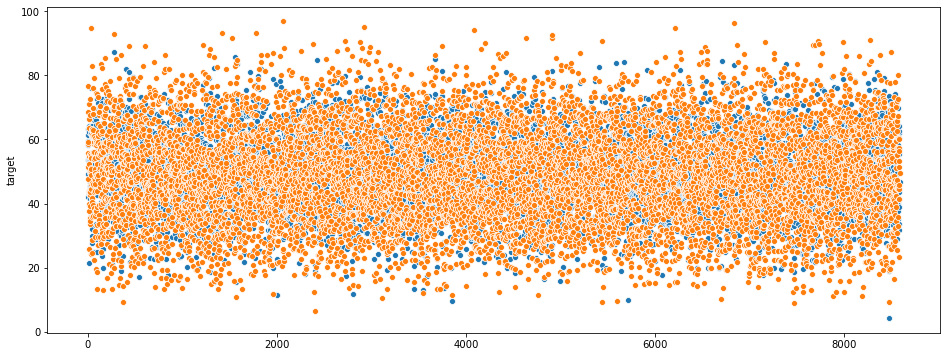

In [112]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 6))
sns.scatterplot(train.index, oof)
sns.scatterplot(train.index, y)

In [91]:
y = train.target
target_class=train['target_class']
num_cols = list(set(test.select_dtypes('number')).intersection(train.select_dtypes('number')))

X = train[num_cols]
X['na']=pd.read_csv('Train.csv')['id_enumerator'].isna().astype(int)
test['na']=pd.read_csv('Test.csv')['id_enumerator'].isna().astype(int)
train_null=pd.read_csv('Train.csv')[train.columns[:7]].isna().astype(int).add_suffix('_null')
X[train_null.columns]=train_null
test_null=pd.read_csv('Test.csv')[train.columns[:7]].isna().astype(int).add_suffix('_null')
test[test_null.columns]=test_null

X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.20, random_state=5000,)
model =CatBoostRegressor(n_estimators=2000,  learning_rate=0.05104963456, loss_function='RMSE')
model.fit(X_train, y_train, verbose=300, early_stopping_rounds=300, use_best_model=True)
y_pred=model.predict(X_test)

You should provide test set for use best model. use_best_model parameter has been switched to false value.


0:	learn: 14.8663154	total: 14.3ms	remaining: 28.6s
300:	learn: 9.2378487	total: 2.08s	remaining: 11.7s
600:	learn: 8.0866656	total: 4.18s	remaining: 9.74s
900:	learn: 7.2440670	total: 6.13s	remaining: 7.48s
1200:	learn: 6.5701860	total: 8.17s	remaining: 5.43s
1500:	learn: 6.0135284	total: 10.3s	remaining: 3.42s
1800:	learn: 5.5330969	total: 12.2s	remaining: 1.35s
1999:	learn: 5.2525845	total: 13.5s	remaining: 0us


<AxesSubplot:ylabel='target'>

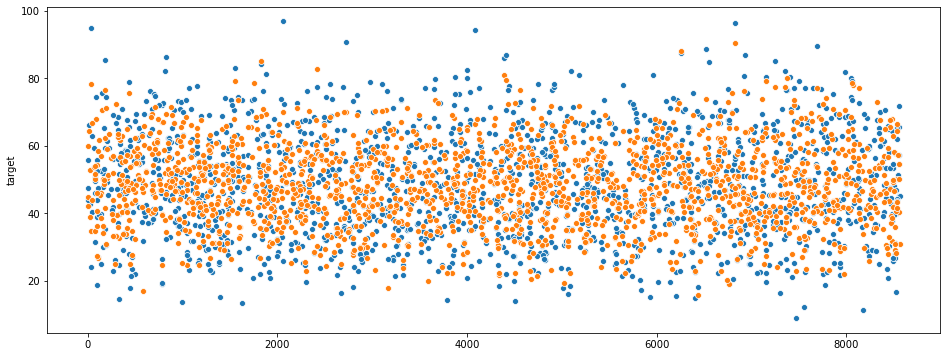

In [92]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 6))
sns.scatterplot(y_test.index, y_test)
sns.scatterplot(y_test.index, y_pred)

In [113]:
feat_impo=pd.DataFrame(model.feature_importances_, X.columns).sort_values(by=0, ascending=False)
feat_impo

,0
child_age,12.524016
child_observe_total,8.609683
id_enumerator,8.165270
child_height,3.614359
teacher_emotional_total,3.532269
child_observe_attentive,2.819437
child_observe_diligent,2.685154
child_id,2.599221
yearmonthday_child_date,2.352211
id_facility,2.174017


<AxesSubplot:>

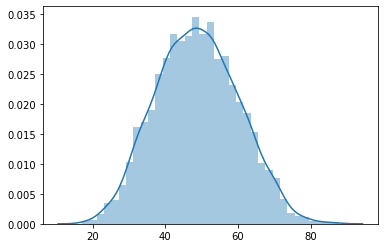

In [114]:
import seaborn as sns
sns.distplot(preds)

In [94]:
display(pd.Series(preds).describe())
y.describe()

count    3680.000000
mean       48.691917
std        11.037369
min        15.363037
25%        40.756251
50%        48.778941
75%        56.283674
max        89.444349
dtype: float64

count    8585.000000
mean       48.693783
std        15.160414
min         6.370000
25%        37.599998
50%        48.310001
75%        59.310001
max        96.809998
Name: target, dtype: float64

In [69]:
sub=pd.read_csv('SampleSubmission.csv')
sub['target']=preds

In [70]:
sub.to_csv('cat_.csv', index=False)
sub

,child_id,target,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15
0,ID_0I0999N6S,59.894141,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature
1,ID_GQ6ONJ4FP,48.247372,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature
2,ID_YZ76CVRW3,51.016117,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature
3,ID_BNINCRXH8,68.464417,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature
4,ID_1U7GDTLRI,41.187072,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3675,ID_LBPQ2VMQZ,52.245682,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature
3676,ID_H2RKKMMKK,52.658913,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature
3677,ID_VY8KX7YTZ,45.698769,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature
3678,ID_EO2MYZ4M7,38.453337,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature


##Note
- Please note that you are not restricted to use eli5 for model interpretability. You can use any other open source libraries like:
      - SHAP
      - LIME
      - Yellowbrick
      - Lucid
      - ... and any other